# TM10007 Assignment
Made by: Sifra Kuiper, Imme Spiekerman, Florien Algera and Nico Frijns

**Explanation of what this code will achieve**

This part of the code will connect this document to the github-location where the data is stored.

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git
!pip install fast_ml --upgrade

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.0 MB/s eta 0:00:00


## import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn import datasets
from worclipo.load_data import load_data
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_duplicate_features
from sklearn.model_selection import learning_curve

## Pre-processing

#Def used in Pre-processing
all the def that are used during pre-processing

In [ ]:
# Counting the different labels
def ratio_lipoma_liposarcoma(y):
  lipoma = 0
  liposarcoma = 0
  for i in y['label']:
    if i == "lipoma":
      lipoma += 1
    else:
      liposarcoma += 1
  return f'Ratio van lipoma and liposarcoma is: {lipoma} : {liposarcoma}'

# making a def for printing amount features
def amount(X):
  return print(f"Amount of features is: {len(X.columns)}")



## Data loading

Loading the data And extracting basic data. And splitting data in label and features.

In [ ]:
# Data loading functions. Uncomment the one you want to use
data = load_data()

# Printing the demensions of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

#splitting data into X and y
y  = data['label']
X = data[data.columns[1:]]
y = pd.DataFrame(y)
X = pd.DataFrame(X)
print(f'The number of samples: {len(X.index)}')
print(f'The number of samples: {len(y.index)}')
ratio_lipoma_liposarcoma(y)

The number of samples: 115
The number of columns: 494
The number of samples: 115
The number of samples: 115


'Ratio van lipoma and liposarcoma is: 57 : 58'

## Splitting the data into training and test

We will split the data in a training en test set with the following ratio 4:1 (training:test) using a stratified split.



In [ ]:
# making the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,  stratify=y)

print(f'Train {ratio_lipoma_liposarcoma(y_train)}')
print(f'Test {ratio_lipoma_liposarcoma(y_test)}')
X_train.info()

Train Ratio van lipoma and liposarcoma is: 46 : 46
Test Ratio van lipoma and liposarcoma is: 11 : 12
<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Lipo-059_0 to Lipo-006_0
Columns: 493 entries, PREDICT_original_sf_compactness_avg_2.5D to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25)
memory usage: 355.1+ KB


## Checking for missing data


Total missing datapoints train set: 13
Total missing datapoints test set: 4
Amount of features is: 464
Amount of features is: 464


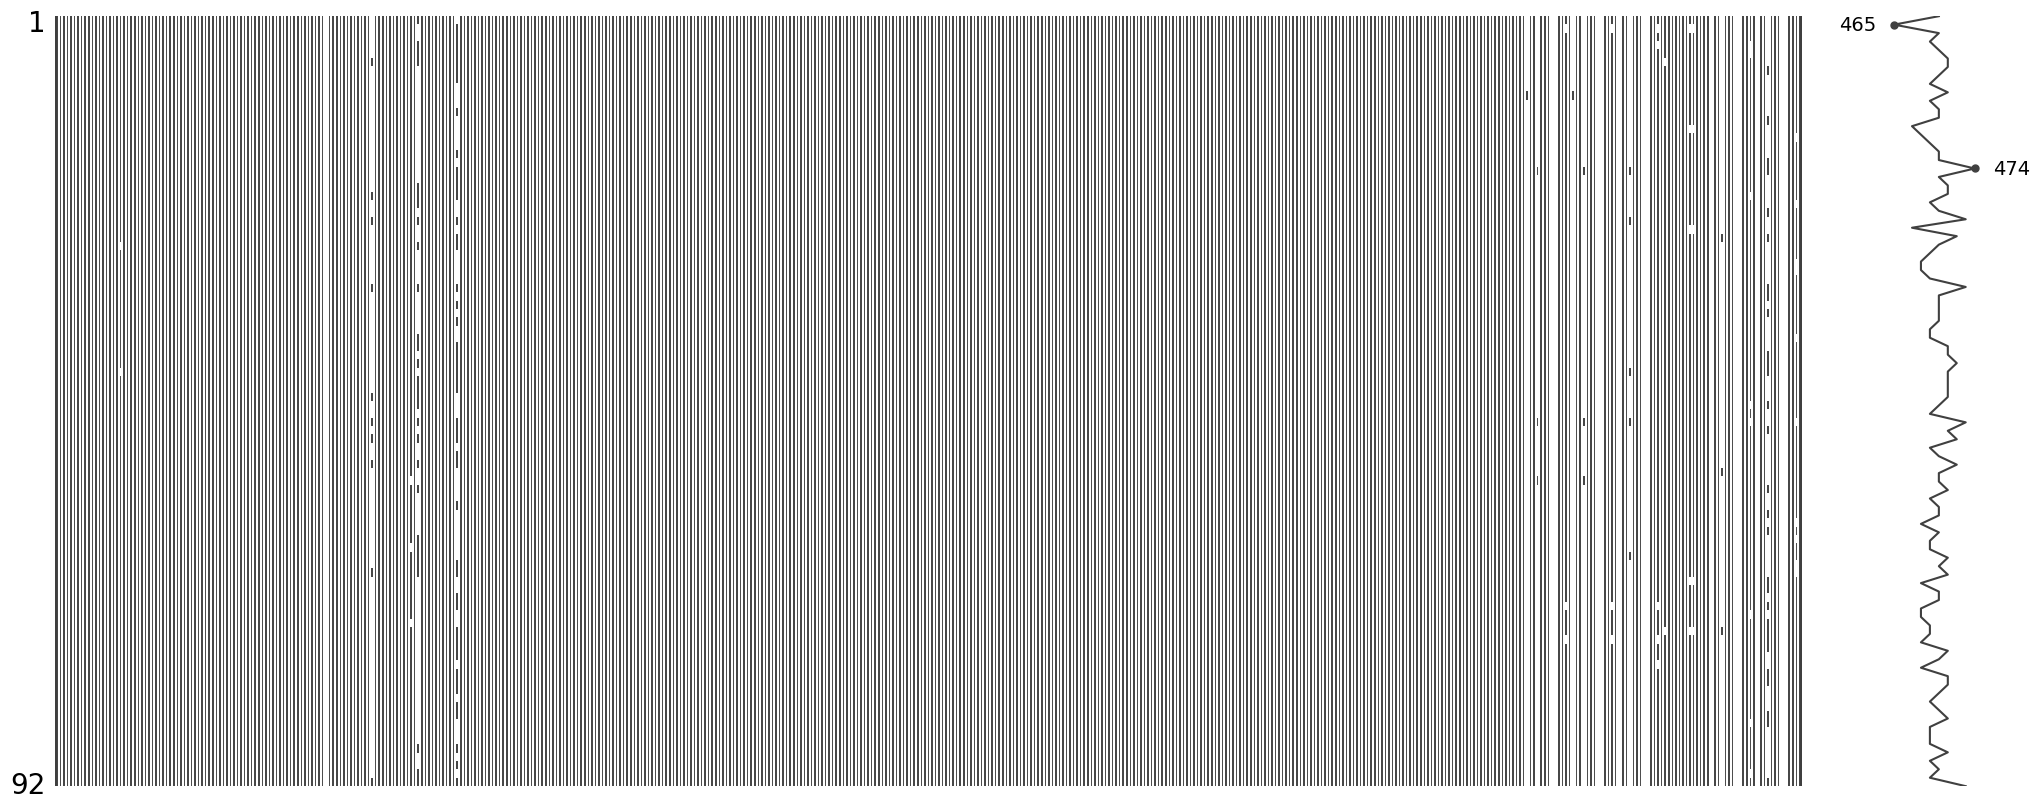

In [ ]:
# Store original data types
original_dtypes_train = X_train.dtypes
original_dtypes_test = X_test.dtypes

# Replace zeros with NaNs
X_selected_train_nan = X_train.replace(0, np.nan)
X_selected_test_nan = X_test.replace(0, np.nan)

# Making a missingo matrix
msno.matrix(X_selected_train_nan)

# Calculate the percentage of NaN values for each feature
nan_percentage_train = (X_selected_train_nan.isnull().sum() / len(X_selected_train_nan)) * 100

# Identify columns with more than 5% NaN values
columns_to_exclude_train = nan_percentage_train[nan_percentage_train > 5].index

# Exclude columns with more than 5% NaN values from the training set
X_selected_train_filtered = X_selected_train_nan.drop(columns=columns_to_exclude_train)

# Amount of missing data points within the trainset
print(f'Total missing datapoints train set: {X_selected_train_filtered.isnull().sum().sum()}')

# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the filtered training set
imputer.fit(X_selected_train_filtered)

# Impute missing values in the training set and convert to DataFrame
X_train = pd.DataFrame(imputer.transform(X_selected_train_filtered), columns=X_selected_train_filtered.columns, index=X_selected_train_filtered.index)

# Apply the same filtering and imputation steps to the test set
X_selected_test_filtered = X_selected_test_nan.drop(columns=columns_to_exclude_train)
X_test = pd.DataFrame(imputer.transform(X_selected_test_filtered), columns=X_selected_test_filtered.columns, index=X_selected_test_filtered.index)

print(f'Total missing datapoints test set: {X_selected_test_filtered.isnull().sum().sum()}')

for column in X_train.columns:
    if column in original_dtypes_train.index:
        X_train[column] = X_train[column].astype(original_dtypes_train[column])

# Reapply original data types for the test set
for column in X_test.columns:
    if column in original_dtypes_test.index:
        X_test[column] = X_test[column].astype(original_dtypes_test[column])

amount(X_train)
amount(X_test)

## Checking for variance
Removing zero-variance features

In [ ]:
# Record the column names and data types
original_columns_train = X_train.columns
original_dtypes_train = X_train.dtypes
# Create an instance of VarianceThreshold
selector = VarianceThreshold()

# Fit the selector to your training data
selector.fit(X_train)

# Get the indices of the features that are kept after feature selection
kept_features_indices = selector.get_support(indices=True)

# Get the names of the kept features
kept_features_names = X_train.columns[kept_features_indices]

# Transform the training data and create a new DataFrame with the kept features
relevant_features_train = selector.transform(X_train)
X_train = pd.DataFrame(relevant_features_train,
                                columns=kept_features_names,
                                index=X_train.index)
# setting features back to orginale datatype
for column in X_train.columns:
  if column in original_columns_train:
    X_train[column] = X_train[column].astype(
        original_dtypes_train[column])
# Print the original DataFrame, transformed DataFrame,
# and the number of zero-variance features


# Test data same transformation as train
original_columns_test = X_test.columns
original_dtypes_test = X_test.dtypes
relevant_features_test = selector.transform(X_test)
X_test = pd.DataFrame(relevant_features_test,
                               columns=kept_features_names, index=X_test.index)
for column in X_test.columns:
  if column in original_columns_test:
    X_test[column] = X_test[column].astype(
        original_dtypes_test[column])

amount(X_train)
amount(X_test)

Amount of features is: 456
Amount of features is: 456


## Checking for duplicates

In this code a check will be conducted to check if there are any duplicate features or rows.

In [ ]:
# check of there are no duplicated features and rows by using the index
if  X_train.index.is_unique:
  print('Features and rows are unique by name')
else:
  print('There is a duplicated features and/or rows by name')

duplicate_features = get_duplicate_features(X_train)
duplicate_features.head()
duplicate_features_list = duplicate_features.query(
    "Desc=='Duplicate Values'")['feature2'].to_list()
X_train.drop(columns=duplicate_features_list, inplace=True)
X_test.drop(columns=duplicate_features_list, inplace=True)
amount(X_train)
amount(X_test)

Features and rows are unique by name
Amount of features is: 441
Amount of features is: 441


## Data checking datatype
Checking the data types used for the futeres and analyzing the int data

In [ ]:
X_train.info()
# want to have the name of the int to check if it is a catogirsed data
integer_features = X_train.select_dtypes(include='int64').columns.tolist()
print("Integer features:")
print(integer_features)

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, Lipo-059_0 to Lipo-006_0
Columns: 441 entries, PREDICT_original_sf_compactness_avg_2.5D to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(424), int64(17)
memory usage: 319.7+ KB
Integer features:
['PREDICT_original_hf_peak_position', 'PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_logf_peak_position_sigma5', 'PREDICT_original_logf_peak_position_sigma10', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A1.57', 'PREDICT_original_tf_Gabor_peak_position_F0.05_A2.36', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.0', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A0.79', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A1.57', 'PREDICT_original_tf_Gabor_peak_position_F0.2_A2.36', 'PREDICT_original_tf_Gabor_peak_position_F0.5_A0.0', 'PREDICT_original_

Want to make a plot of all the int data to see if it is categorized data is.

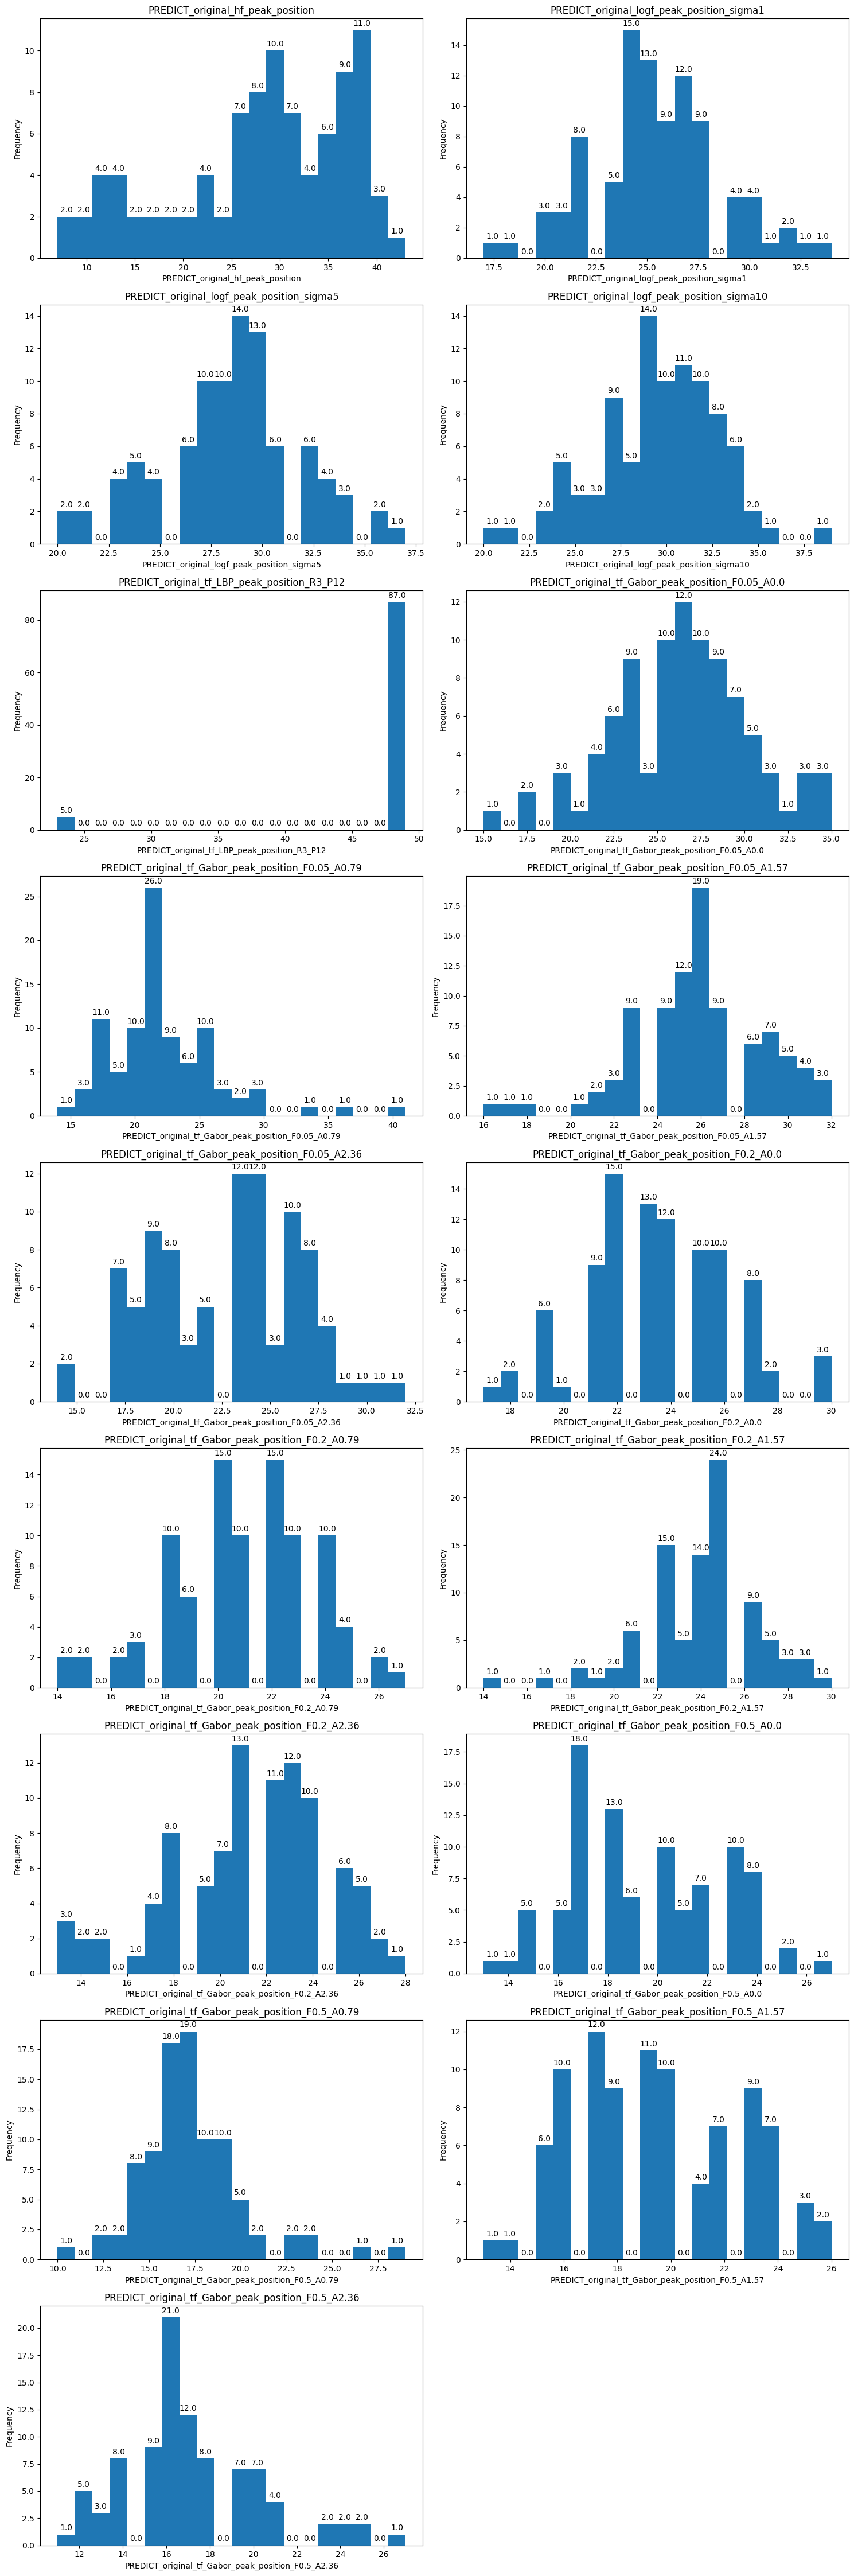

In [ ]:
# Assuming features_set is your set of features
num_features = len(integer_features)
num_cols = 2  # Number of columns in the subplot grid
num_rows = -(-num_features // num_cols)  # Ceiling division to calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, feature in enumerate(integer_features):
    if feature in X_train.columns:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        X_train[feature].plot(kind='hist', bins=20, ax=axes[row, col], title=feature)
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Frequency')
        # Annotate each bar with its count
        for rect in ax.patches:
            height = rect.get_height()
            ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom')

# Hide empty subplots if the number of features is not a multiple of num_cols
for i in range(num_features, num_rows*num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

## Check for outliers
calculating a percentages of outliner in the total dataset using the IQR method.


In [ ]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)

# Calculate the IQR (Interquartile Range) for each column
IQR = Q3 - Q1

# Identify outliers using the IQR method
# Any value below Q1 - 1.5 * IQR
# or above Q3 + 1.5 * IQR is considered an outlier
outliers = ((X_train < (Q1 - 1.5 * IQR)) |
 (X_train > (Q3 + 1.5 * IQR))).sum().sum()

# Calculate the percentage of outliers
total_data_points = X_train.size
total_percentage_outliers = (outliers / total_data_points) * 100

# Print the percentage of outliers for each column
print(f"Percentage of outliers: {total_percentage_outliers}")

Percentage of outliers: 4.877748200729568


## Standardization
Given the amount of outliners in the that set standardization is used. This because it is less affected by the outliners.

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled,
                                 columns=X_train.columns,
                                 index=X_train.index)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_train)
X_test_scaled_df = pd.DataFrame(X_test_scaled,
                                columns=X_train.columns,
                                index=X_train.index)
X_train = X_train_scaled_df
X_test = X_test_scaled_df


# Try PCA
-> Did not work, do not run this code

                  PC1        PC2       target
Lipo-059_0  -8.711909 -12.743620  liposarcoma
Lipo-090_0  18.322194  -0.740832       lipoma
Lipo-046_0   4.568990 -12.262642  liposarcoma
Lipo-013_0  -1.309985  -5.759032  liposarcoma
Lipo-034_0  -5.267314  -1.175807       lipoma


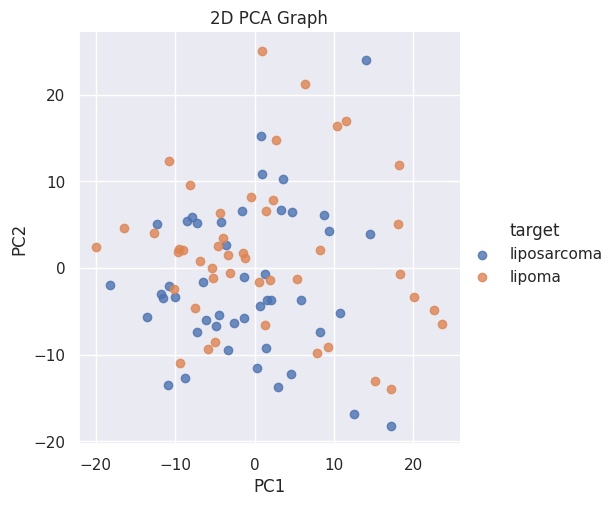

In [ ]:
# Hyperparameters to tune:
numb_components = 70     # number of components

# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=numb_components)

# Fit and transform data
pca_features = pca.fit_transform(X_train)

# Create a DataFrame from pca_features with column names 'PC1' and 'PC2'
pca_df = pd.DataFrame(data=pca_features[:, :2], columns=['PC1', 'PC2'])

pca_df = pca_df.rename(index=dict(zip(pca_df.index, y_train.index)))

# Add the labels from y_train to the DataFrame
pca_df['target'] = y_train

print(pca_df.head())

# Define target names mapping
target_names = {
    'lipoma': 'lipoma',
    'liposarcoma': 'liposarcoma'
}

# Map target names to the 'target' column in pca_df
pca_df['target'] = pca_df['target'].map(target_names)

# Set seaborn style
sns.set()

# Plot the PCA graph
sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,  # Disable regression line
    legend=True
)

# Set plot title
plt.title('2D PCA Graph')

# Show the plot
plt.show()

#Overview of the performance of Top 50 features

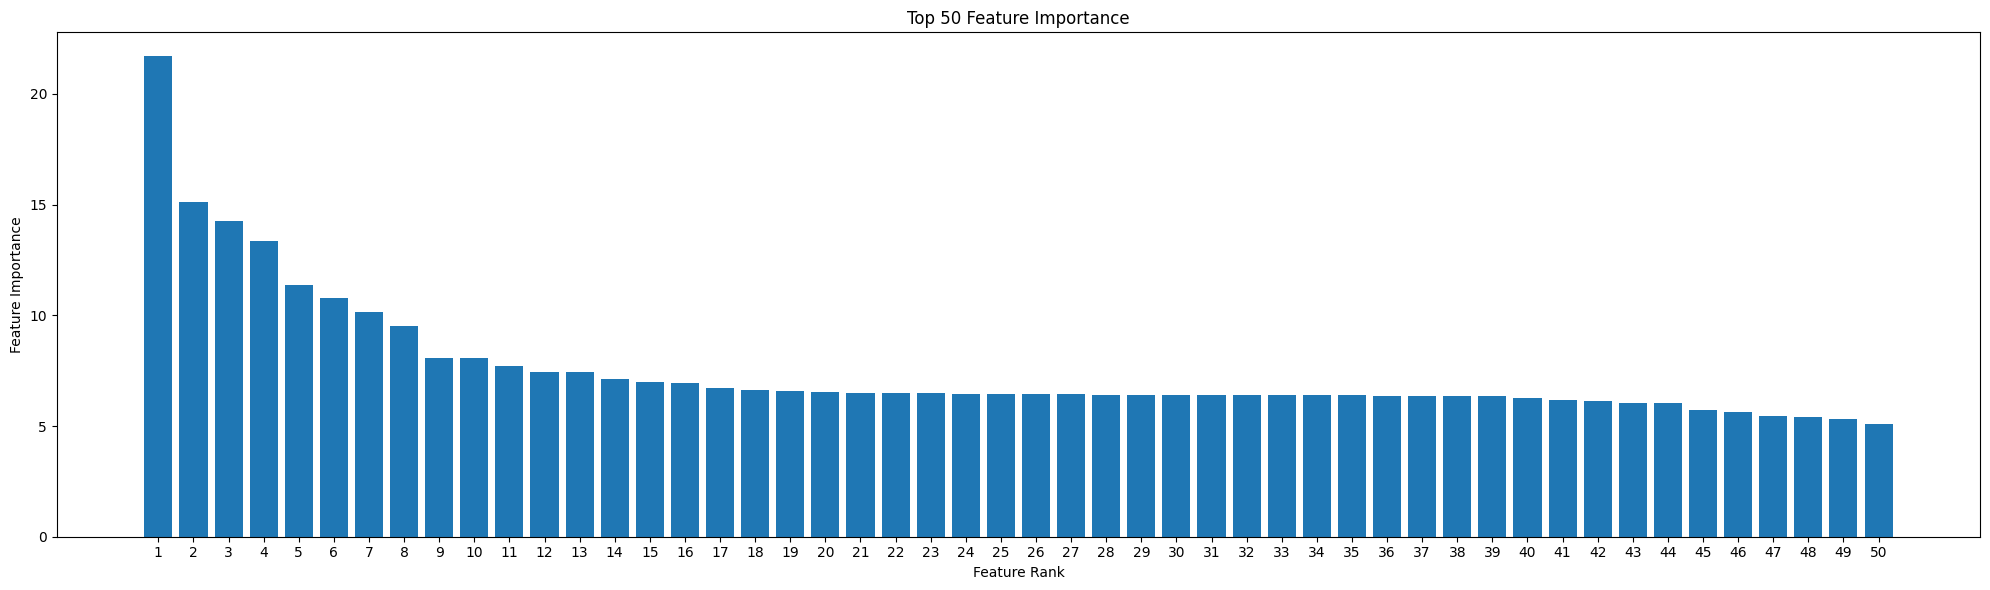

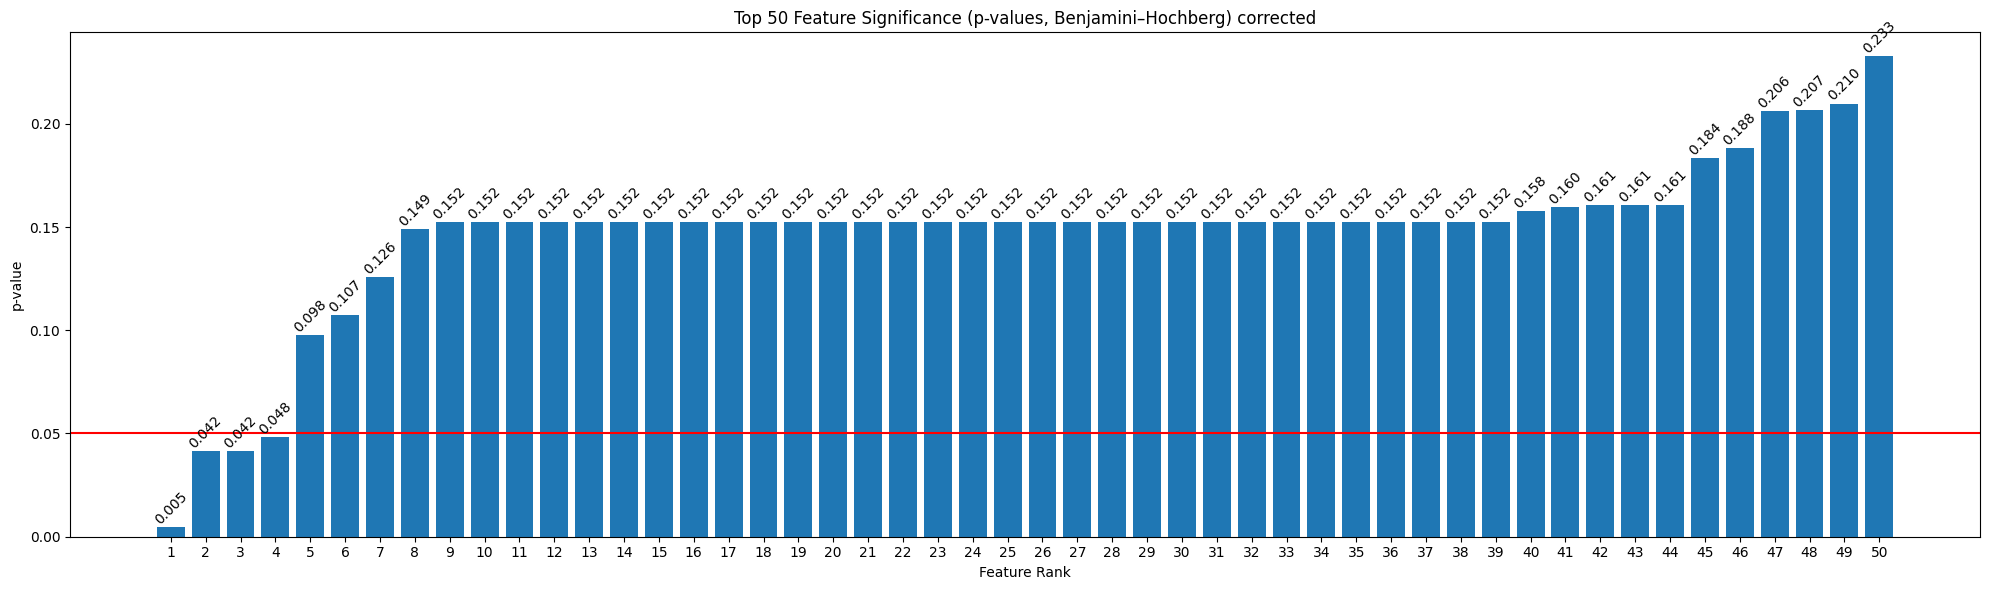

In [ ]:

# ---------------------FEATURE SELECTION -----------------------------------------------
# HYPERPARAMETER = aantal features om te selecteren

N1 = 4;
N2 = 15;
N3 = 50;

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values.ravel())

# -------  ANOVA

# Compute F-statistics and p-values using f_classif
F_values, p_values = f_classif(X_train, y_train_encoded)

# Bonferroni correction on the p-values to correct for multiple testing
_, p_adjusted, _, alpha_corrected = multipletests(p_values, method='fdr_bh')

# Create a DataFrame with feature names, F-values, and p-values
feature_stats_df = pd.DataFrame({'F-value': F_values, 'p-value': p_adjusted}, index=X_train.columns)

# Sort features based on absolute correlation values and select top 20
sorted_features_1 = feature_stats_df.abs().nlargest(N1, 'F-value')
sorted_features_2 = feature_stats_df.abs().nlargest(N2, 'F-value')
sorted_features_3 = feature_stats_df.abs().nlargest(N3, 'F-value')

# Maak nieuwe kleinere datasets met minder features
X_train_sel_1 = X_train.loc[:, sorted_features_1.index]
X_train_sel_2 = X_train.loc[:, sorted_features_2.index]
X_train_sel_3 = X_train.loc[:, sorted_features_3.index]

# ------- plot met feature importance --------

# Sort features based on absolute correlation values and select top 20
sorted_features = feature_stats_df.abs().nlargest(50, 'F-value')

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(range(1, 51), sorted_features['F-value'])
plt.title('Top 50 Feature Importance')
plt.xlabel('Feature Rank')
plt.ylabel('Feature Importance')
plt.xticks(range(1, 51))
plt.tight_layout()
plt.show()


# ------- plot met p-waardes --------

# Assuming you have already sorted your features and selected the top 10
sorted_features = feature_stats_df.nsmallest(50, 'p-value')

plt.figure(figsize=(20, 6))
bars = plt.bar(range(1, 51), sorted_features['p-value'])
plt.title('Top 50 Feature Significance (p-values, Benjamini–Hochberg) corrected')
plt.xlabel('Feature Rank')
plt.ylabel('p-value')
plt.xticks(range(1, 51))  # Adjusted xticks to start from 1
plt.tight_layout()
plt.axhline(y=0.05, color='r', linestyle='-')

# Function to add value labels
def addlabels(x, y):
    for i, val in enumerate(y):
        plt.text(x[i], val, f'{val:.3f}', ha='center', va='bottom', rotation=45)  # Rotating text 90 degrees

addlabels(range(1, 51), sorted_features['p-value'])

plt.show()


# Choosing the classifier

Max N value for LinSVM: 14
Max N value for K-NN: 2
Max N value for RF: 37


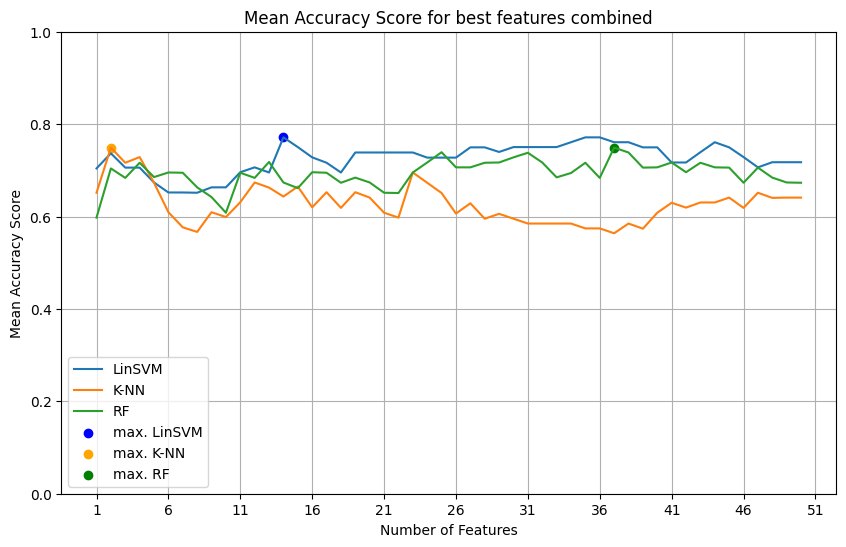

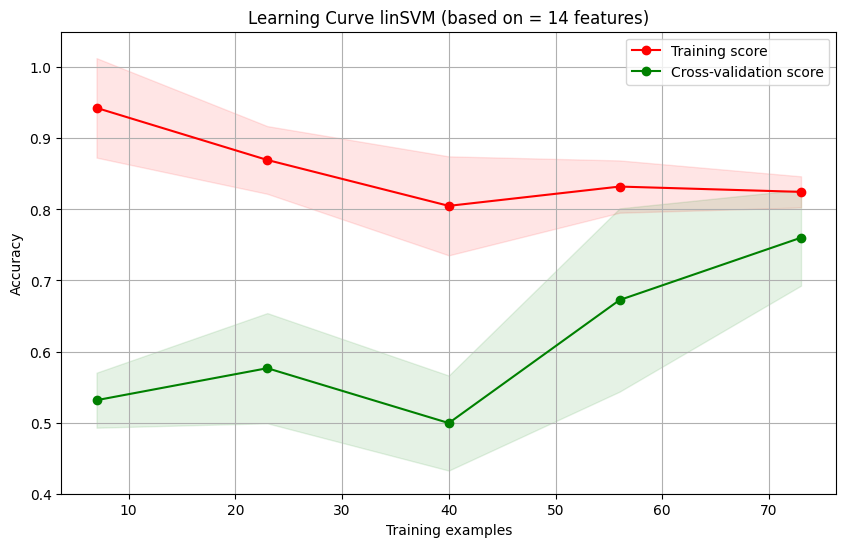

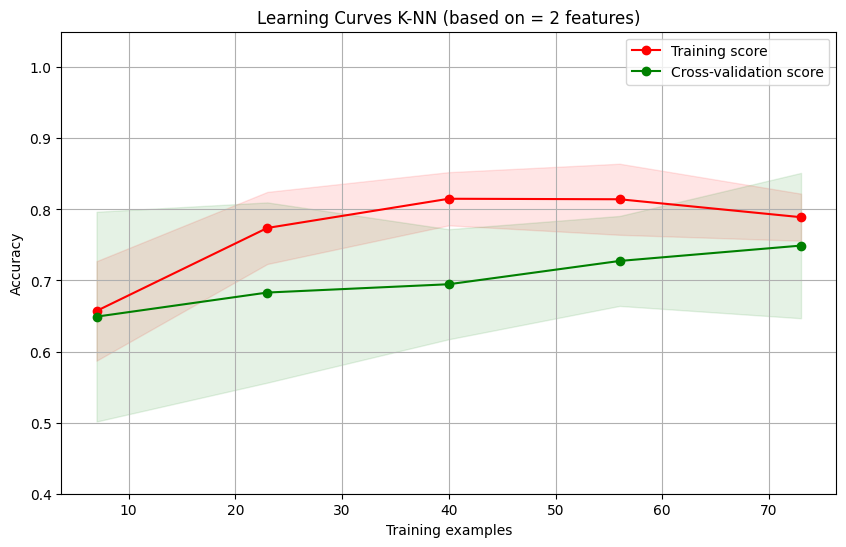

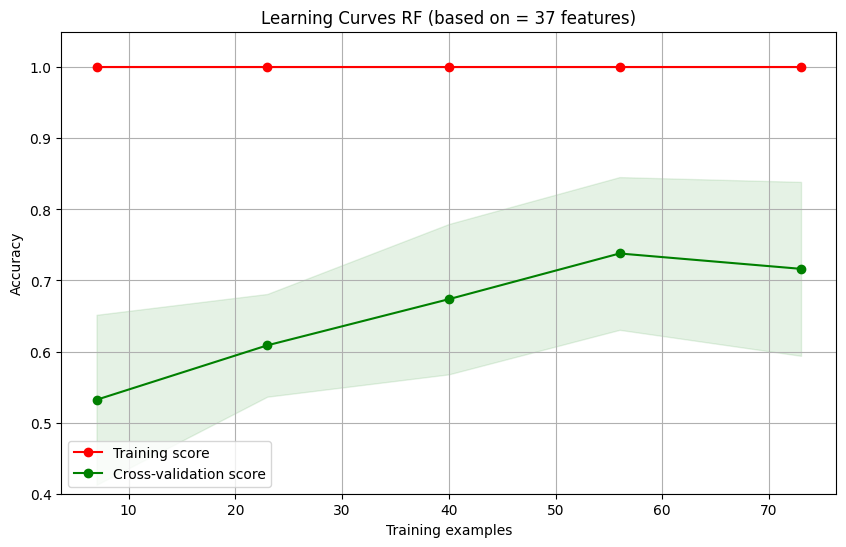

In [ ]:
def select_top_features(X_train, y_train_encoded, N):
    F_values, _ = f_classif(X_train, y_train_encoded)
    feature_stats_df = pd.DataFrame({'F-value': F_values}, index=X_train.columns)
    sorted_features = feature_stats_df.abs().nlargest(N, 'F-value')
    X_train_sel = X_train.loc[:, sorted_features.index]

    return X_train_sel, y_train_encoded

# Definiëren
N_values = range(1, 51)
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier()]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisatie van de lijsten voor het opslaan van resultaten
mean_scores = {cls.__class__.__name__: [] for cls in classifiers}
std_scores = {cls.__class__.__name__: [] for cls in classifiers}

# Itereren over verschillende N-waarden
for N in N_values:
    # Feature selectie
    X_train_sel, y_train_encoded = select_top_features(X_train, y_train_encoded, N)

    # Scores voor elke classifier berekenen
    for cls in classifiers:
        scores = cross_val_score(cls, X_train_sel, y_train_encoded, scoring='accuracy', cv=cv)  # Hier de scoring veranderd
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        mean_scores[cls.__class__.__name__].append(mean_score)
        std_scores[cls.__class__.__name__].append(std_score)

#Bepalen beste aantal features
max_accuracy_SVM = max(mean_scores['SVC'])
max_accuracy_KNN = max(mean_scores['KNeighborsClassifier'])
max_accuracy_RF = max(mean_scores['RandomForestClassifier'])

N_SVM = N_values[mean_scores['SVC'].index(max_accuracy_SVM)]
N_KNN = N_values[mean_scores['KNeighborsClassifier'].index(max_accuracy_KNN)]
N_RF = N_values[mean_scores['RandomForestClassifier'].index(max_accuracy_RF)]

# Printen van de resultaten
print("Max N value for LinSVM:", N_SVM)
print("Max N value for K-NN:", N_KNN)
print("Max N value for RF:", N_RF)

# Plotten van de resultaten
plt.figure(figsize=(10, 6))

for cls in classifiers:
    plt.plot(N_values, mean_scores[cls.__class__.__name__], label=cls.__class__.__name__)

plt.scatter(N_SVM, max_accuracy_SVM, color='blue', label='Max LinSVM', marker='o')
plt.scatter(N_KNN, max_accuracy_KNN, color='orange', label='Max K-NN', marker='o')
plt.scatter(N_RF, max_accuracy_RF, color='green', label='Max RF', marker='o')

plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy Score')
plt.title('Mean Accuracy Score for best features combined')
plt.xticks(np.arange(1, 52, 5))
plt.ylim(0, 1)
plt.legend(['LinSVM', 'K-NN', 'RF', 'max. LinSVM','max. K-NN', 'max. RF' ])
plt.grid(True)
plt.show()


## --------------- Learning curves ---------------------

# Functie voor het plotten van de learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    if ylim is not None:
        plt.ylim(ylim)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Definiëren van de limieten voor de y-as
ylim = (0.4, 1.05)

X_train_sel_SVM = select_top_features(X_train, y_train_encoded, N_SVM)[0]
X_train_sel_KNN = select_top_features(X_train, y_train_encoded, N_KNN)[0]
X_train_sel_RF = select_top_features(X_train, y_train_encoded, N_RF)[0]

title_SVM = "Learning Curve linSVM (based on = %s features)" % N_SVM
title_KNN = "Learning Curves K-NN (based on = %s features)" % N_KNN
title_RF = "Learning Curves RF (based on = %s features)" % N_RF

# Plotten van de learning curves voor SVM
estimator_SVM = SVC()
plot_learning_curve(estimator_SVM, title_SVM, X_train_sel_SVM, y_train_encoded, cv=cv, n_jobs=-1,ylim=ylim)

# Plotten van de learning curves voor KNN
estimator_KNN = KNeighborsClassifier()
plot_learning_curve(estimator_KNN, title_KNN, X_train_sel_KNN, y_train_encoded, cv=cv, n_jobs=-1,ylim=ylim)

# Plotten van de learning curves voor RF
estimator_RF = RandomForestClassifier()
plot_learning_curve(estimator_RF, title_RF, X_train_sel_RF, y_train_encoded, cv=cv, n_jobs=-1,ylim=ylim)

plt.show()


# KNN Classifier

Testen KNN classifier op N_KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the KNN classifier
knn = KNeighborsClassifier()

# Perform cross-validation
scores_sel_KNN = cross_val_score(knn, X_train_sel_KNN, y_train_encoded, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold:", scores_sel_KNN)


# Print the mean accuracy across all folds
print("Mean accuracy:", scores_sel_KNN.mean())


# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_sel_KNN = scores_sel_KNN.mean()
plt.axhline(y=mean_accuracy_sel_KNN, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_KNN})')
for i, score in enumerate(scores_sel_1):
    plt.bar(i + 0.1, score, width=0.15, color='gray')


plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Scores for KNN')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

Hyperparameterisatie KNN

In [ ]:
from sklearn.model_selection import GridSearchCV

knn_to_opt = KNeighborsClassifier()

# Perform cross-validation
#scores_to_opt = cross_val_score(knn, X_train_sel_1, y_train_encoded, cv=5)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_to_opt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sel_KNN, y_train_encoded)

# Get the best hyperparameters and the best score
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)
print("Best accuracy found by Grid Search:", grid_search.best_score_)

Plot optimalizatie KNN

In [ ]:
knn_opt = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=20, p=1, metric='minkowski', metric_params=None, n_jobs=None)

# Perform cross-validation
scores_opt_KNN = cross_val_score(knn_opt, X_train_sel_KNN, y_train_encoded, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold:", scores_opt_KNN)

# Print the mean accuracy across all folds
print("Mean accuracy:", scores_opt_KNN.mean())

# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_opt_KNN = scores_opt_KNN.mean()
plt.axhline(y=mean_accuracy_opt_KNN, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_KNN})')
plt.text(0.5, mean_accuracy_opt_KNN + 0.20, f'Mean Accuracy: {mean_accuracy_opt_KNN:.4f}', ha='right')
for i, score in enumerate(scores_sel_KNN):
    plt.bar(i + 0.1, score, width=0.3, color='blue')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Optimized Cross-validation Scores for KNN')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Random Forest

Testen Random Forest op N_RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the KNN classifier
RF = RandomForestClassifier()

# Perform cross-validation
scores_sel_RF = cross_val_score(RF, X_train_sel_RF, y_train_encoded, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold:", scores_sel_RF)


# Print the mean accuracy across all folds
print("Mean accuracy:", scores_sel_RF.mean())


# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_sel_RF = scores_sel_RF.mean()
plt.axhline(y=mean_accuracy_sel_RF, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_RF})')
for i, score in enumerate(scores_sel_RF):
    plt.bar(i + 0.1, score, width=0.15, color='gray')


plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Scores for RF')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

Hyperparameter optimalizatie RF

In [ ]:
from sklearn.model_selection import GridSearchCV

RF_to_opt = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(RF_to_opt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sel_RF, y_train_encoded)

# Get the best hyperparameters and the best score
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)
print("Best accuracy found by Grid Search:", grid_search.best_score_)

Visualisatie RF

In [ ]:
RF_opt = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
scores_opt_RF = cross_val_score(RF_opt, X_train_sel_RF, y_train_encoded, cv=5)
# Print the accuracy for each fold
print("Accuracy for each fold:", scores_opt_RF)

# Print the mean accuracy across all folds
print("Mean accuracy:", scores_opt_RF.mean())

# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_opt_RF = scores_opt_RF.mean()
plt.axhline(y=mean_accuracy_opt_RF, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_RF})')
plt.text(0.5, mean_accuracy_opt_RF + 0.20, f'Mean Accuracy: {mean_accuracy_opt_RF:.4f}', ha='right')
for i, score in enumerate(scores_sel_RF):
    plt.bar(i + 0.1, score, width=0.3, color='blue')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Optimized Cross-validation Scores for RF')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# linSVM

Testen linSVM op N_SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define the KNN classifier
linSVM = LinearSVC()

# Perform cross-validation
scores_sel_SVM = cross_val_score(linSVM, X_train_sel_SVM, y_train_encoded, cv=5)

# Print the accuracy for each fold
print("Accuracy for each fold:", scores_sel_SVM)


# Print the mean accuracy across all folds
print("Mean accuracy:", scores_sel_SVM.mean())


# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_sel_SVM = scores_sel_SVM.mean()
plt.axhline(y=mean_accuracy_sel_SVM, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_SVM})')
for i, score in enumerate(scores_sel_SVM):
    plt.bar(i + 0.1, score, width=0.15, color='gray')


plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Scores for SVM')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

Hyperparamterisatie optimalizatie linSVM

In [ ]:
from sklearn.model_selection import GridSearchCV

svm_to_opt = LinearSVC()

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'loss': ['squared_hinge'],  # Loss function (only squared_hinge)
    'penalty': ['l2'],  # Penalty norm
    'dual': [False],  # Whether to solve the primal or dual optimization problem
    'max_iter': [1000]  # Maximum number of iterations
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_to_opt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sel_SVM, y_train_encoded)

# Get the best hyperparameters and the best score
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)
print("Best accuracy found by Grid Search:", grid_search.best_score_)

Visualizatie opt linSVM

In [ ]:
SVM_opt = LinearSVC(C=0.1, dual=False, loss='squared_hinge', max_iter=1000, penalty='l2')
scores_opt_SVM= cross_val_score(SVM_opt, X_train_sel_SVM, y_train_encoded, cv=5)
# Print the accuracy for each fold
print("Accuracy for each fold:", scores_opt_SVM)

# Print the mean accuracy across all folds
print("Mean accuracy:", scores_opt_SVM.mean())

# Plotting the scores
plt.figure(figsize=(12,6))

# Plot for selection 1
mean_accuracy_opt_SVM = scores_opt_SVM.mean()
plt.axhline(y=mean_accuracy_opt_SVM, color='blue', linestyle='--', label=f'Mean Accuracy (N= {N_SVM})')
plt.text(0.5, mean_accuracy_opt_SVM + 0.20, f'Mean Accuracy: {mean_accuracy_opt_SVM:.4f}', ha='right')
for i, score in enumerate(scores_sel_SVM):
    plt.bar(i + 0.1, score, width=0.3, color='blue')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Optimized Cross-validation Scores for SVM')
plt.xticks(np.arange(5) + 0.5, np.arange(1, 6))  # Set x-ticks for each fold
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Train classifiers

In [ ]:
# ---------------------CLASSIFIERS -------------------------------------------------------------
"""
classifiers = [
    (svm.SVC(kernel='linear', C=1.0, random_state=42), "LinSVM"),
    (svm.SVC(kernel="rbf", gamma=0.7, C=1.0), "rbfSVM"),
    (svm.SVC(kernel="poly", degree=2, gamma="auto", C=1.0), "polySVM"),
    (HistGradientBoostingClassifier(max_iter=100), "GBDT"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), "RF"),
    (BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), "Bagging meta-estimator"),
    (LogisticRegression(random_state=1), "LR"),
    (GaussianNB(), "NB")
]"""

classifiers = [
    (svm.SVC(kernel='linear', C=1.0, random_state=42), "LinSVM"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0), "RF")]

results = {}
for clf, label in classifiers:
    # Scores berekenen voor N1 aantal features
    scores_N1 = cross_val_score(clf, X_train_sel_1, y_train_encoded, cv=5)
    mean_accuracy_N1 = scores_N1.mean()
    std_dev_N1 = scores_N1.std()

    # Scores berekenen voor N2 aantal features
    scores_N2 = cross_val_score(clf, X_train_sel_2, y_train_encoded, cv=5)
    mean_accuracy_N2 = scores_N2.mean()
    std_dev_N2 = scores_N2.std()

    # Scores berekenen voor N3 aantal features
    scores_N3 = cross_val_score(clf, X_train_sel_3, y_train_encoded, cv=5)
    mean_accuracy_N3 = scores_N3.mean()
    std_dev_N3 = scores_N3.std()

    # Opslaan van resultaten
    results[label + f' ({N1} features)'] = (mean_accuracy_N1, std_dev_N1)
    results[label + f' ({N2} features)'] = (mean_accuracy_N2, std_dev_N2)
    results[label + f' ({N3} features)'] = (mean_accuracy_N3, std_dev_N3)

**Visualization of the performance of the different classifiers**

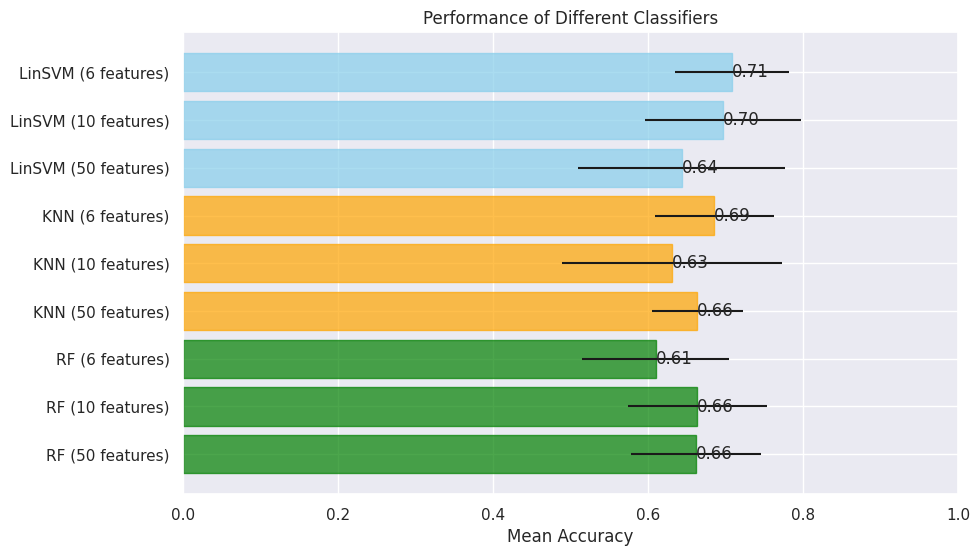

In [ ]:
# Plot resultaten
labels = list(results.keys())
mean_accuracies = [result[0] for result in results.values()]
std_devs = [result[1] for result in results.values()]
colors = ['skyblue', 'skyblue', 'skyblue', 'orange', 'orange', 'orange', 'green', 'green', 'green', 'pink', 'pink', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, mean_accuracies, xerr=std_devs, edgecolor='black', alpha=0.7)

# Loop door elke balk en pas de kleur aan op basis van de index van de classifier in de lijst
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)])  # Gebruik modulo om ervoor te zorgen dat kleuren worden hergebruikt indien nodig
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{mean_accuracies[i]:.2f}', va='center')

plt.xlabel('Mean Accuracy')
plt.title('Performance of Different Classifiers')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()

## Optimalization of the GBDT classifier

**Explanation of code**

In [ ]:
# Define parameter grid for GBDT
param_distributions_gbdt = {
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Define parameter grid for LinSVM
param_distributions_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

# Define parameter grid for LR
param_distributions_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000, 1500]
}

# Perform optimization and training for PCA_80
classifiers = [(GradientBoostingClassifier(), param_distributions_gbdt, 'GBDT'),
               (SVC(), param_distributions_svm, 'LinSVM'),
               (LogisticRegression(), param_distributions_lr, 'LR')]

for clf, param_dist, label in classifiers:
    randomized_search = RandomizedSearchCV(clf, param_dist, cv=5, n_iter=20, random_state=42)
    randomized_search.fit(X_train_PCA80, y_train)
    print(f"Best Parameters for {label} (PCA_80):", randomized_search.best_params_)

# Perform optimization and training for PCA_90
for clf, param_dist, label in classifiers:
    randomized_search = RandomizedSearchCV(clf, param_dist, cv=5, n_iter=20, random_state=42)
    randomized_search.fit(X_train_PCA90, y_train)
    print(f"Best Parameters for {label} (PCA_90):", randomized_search.best_params_)




NameError: name 'np' is not defined

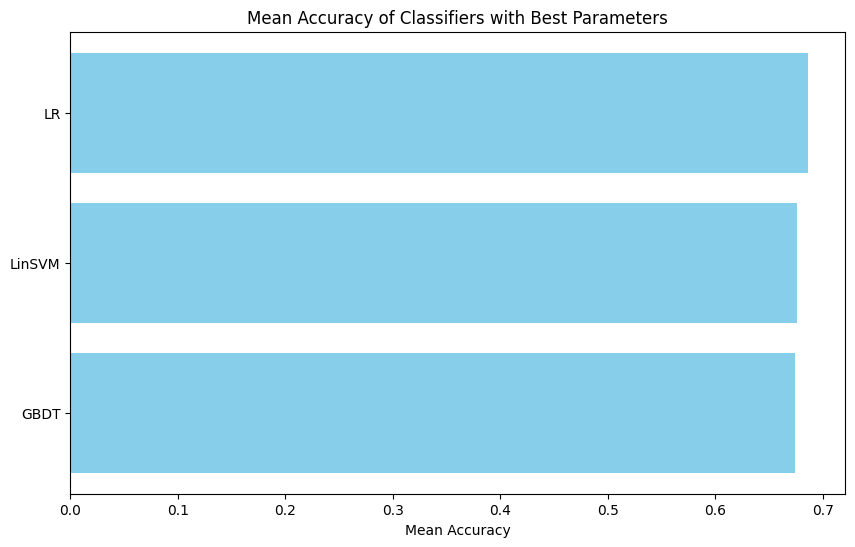

In [ ]:
# Lijsten om beste parameters en mean accuracy op te slaan
best_params_list = []
mean_accuracy_list = []

# Grid search en training voor PCA_80
for clf, param_grid, label in classifiers:
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(X_train_PCA80, y_train)
    best_params = grid_search.best_params_
    mean_accuracy = grid_search.best_score_
    best_params_list.append((label, best_params))
    mean_accuracy_list.append((label, mean_accuracy))

# Grid search en training voor PCA_90
for clf, param_grid, label in classifiers:
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(X_train_PCA90, y_train)
    best_params = grid_search.best_params_
    mean_accuracy = grid_search.best_score_
    best_params_list.append((label, best_params))
    mean_accuracy_list.append((label, mean_accuracy))

# Sorteer mean accuracy van hoog naar laag
mean_accuracy_list.sort(key=lambda x: x[1], reverse=True)

# Plot mean accuracy voor elke classifier
plt.figure(figsize=(10, 6))
classifiers_labels = [clf_label for clf_label, _ in mean_accuracy_list]
mean_accuracies = [accuracy for _, accuracy in mean_accuracy_list]
plt.barh(classifiers_labels, mean_accuracies, color='skyblue')
plt.xlabel('Mean Accuracy')
plt.title('Mean Accuracy of Classifiers with Best Parameters')
plt.gca().invert_yaxis()  # Om de classifiers van hoog naar laag te tonen
plt.show()

## Visualization of the performance of the trained classifier

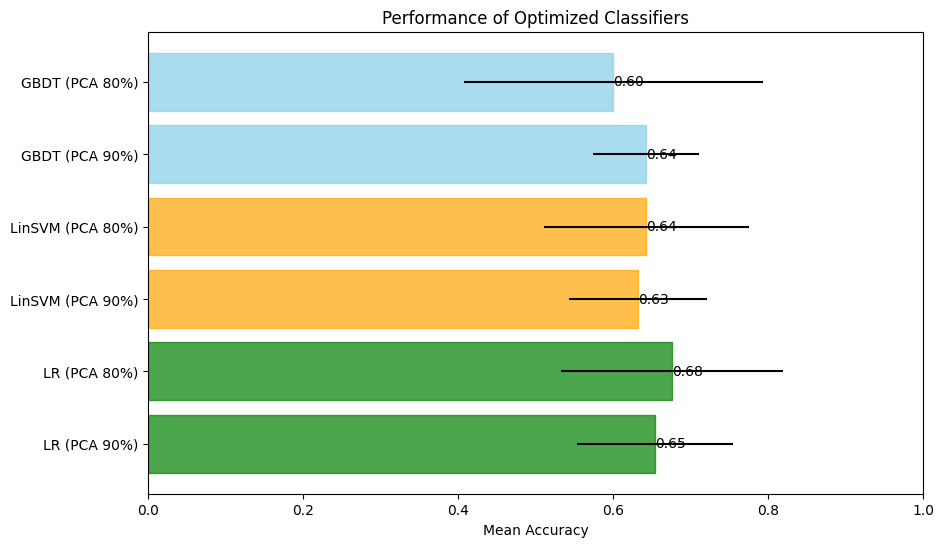

In [ ]:
# Get the mean accuracies and standard deviations of the optimized classifiers
optimized_classifiers = ['GBDT (PCA 80%)', 'GBDT (PCA 90%)', 'LinSVM (PCA 80%)', 'LinSVM (PCA 90%)', 'LR (PCA 80%)', 'LR (PCA 90%)']
mean_accuracies = [results[classifier][0] for classifier in optimized_classifiers]
std_devs = [results[classifier][1] for classifier in optimized_classifiers]

# Define colors for the bars
colors = ['skyblue', 'skyblue', 'orange', 'orange', 'green', 'green']

# Plot the mean accuracies
plt.figure(figsize=(10, 6))
bars = plt.barh(optimized_classifiers, mean_accuracies, xerr=std_devs, edgecolor='black', alpha=0.7)

# Loop through each bar and set its color based on the index of the classifier in the list
for i, bar in enumerate(bars):
    bar.set_color(colors[i % len(colors)])  # Use modulo to ensure colors are reused if necessary
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{mean_accuracies[i]:.2f}', va='center')

plt.xlabel('Mean Accuracy')
plt.title('Performance of Optimized Classifiers')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()



In [ ]:
# Definieer een functie om de leercurve te plotten
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=False)  # Verwijder `return_times=True` omdat we geen fit_times verwachten

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Trainingsvoorbeelden")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Trainingscore")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validatiescore")

    plt.legend(loc="best")
    return plt

# Plot leercurve voor elke classifier
for clf, params, label in classifiers:
    randomized_search = RandomizedSearchCV(clf, params, cv=5, n_iter=20, random_state=42)
    randomized_search.fit(X_train_PCA80, y_train)

    best_estimator = randomized_search.best_estimator_

    plot_learning_curve(best_estimator, f"Learning Curve ({label})", X_train_PCA80, y_train, cv=5)
    plt.show()



NameError: name 'RandomizedSearchCV' is not defined